In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
# setup data loading
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 291027.00it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
# load model
model_name = "flowfa"
d_latent = 3
sample_transform = "learned-leaky"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa(dataloaders, random_seed, **model_config)

In [7]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

# get the indices of the first ten repeated samples
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
# sanity check to see if the wanted samples transform is actually loaded
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Affine(
      init_t=Parameter containing:
      tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0.,

In [9]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 5732.355957).


100%|██████████| 70/70 [00:03<00:00, 22.43it/s]

Epoch 1/500 | train loss: 4216.112793 | val loss: 1909.915283


Score improved (5732.355957 --> 1909.915283).


100%|██████████| 70/70 [00:03<00:00, 21.87it/s]


Epoch 2/500 | train loss: 1782.173462 | val loss: 1589.156494
Score improved (1909.915283 --> 1589.156494).


100%|██████████| 70/70 [00:04<00:00, 15.66it/s]


Epoch 3/500 | train loss: 1463.179077 | val loss: 1534.562378
Score improved (1589.156494 --> 1534.562378).


100%|██████████| 70/70 [00:05<00:00, 13.89it/s]


Epoch 4/500 | train loss: 1620.545776 | val loss: 1520.920166
Score improved (1534.562378 --> 1520.920166).


100%|██████████| 70/70 [00:04<00:00, 14.42it/s]


Epoch 5/500 | train loss: 1574.135620 | val loss: 1521.215820
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.42it/s]


Epoch 6/500 | train loss: 1456.369995 | val loss: 1520.099365
Score improved (1520.920166 --> 1520.099365).


100%|██████████| 70/70 [00:04<00:00, 14.53it/s]


Epoch 7/500 | train loss: 1532.155273 | val loss: 1519.151001
Score improved (1520.099365 --> 1519.151001).


100%|██████████| 70/70 [00:04<00:00, 14.50it/s]


Epoch 8/500 | train loss: 1482.390869 | val loss: 1520.040527
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.59it/s]


Epoch 9/500 | train loss: 1494.619873 | val loss: 1519.477539
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.41it/s]


Epoch 10/500 | train loss: 1551.785645 | val loss: 1521.357666
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.49it/s]


Epoch 11/500 | train loss: 1595.116089 | val loss: 1518.013062
Score improved (1519.151001 --> 1518.013062).


100%|██████████| 70/70 [00:04<00:00, 14.09it/s]


Epoch 12/500 | train loss: 1473.863037 | val loss: 1518.912109
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.22it/s]


Epoch 13/500 | train loss: 1539.271973 | val loss: 1519.664795
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.49it/s]


Epoch 14/500 | train loss: 1534.020752 | val loss: 1523.327515
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:04<00:00, 15.91it/s]


Epoch 15/500 | train loss: 1622.847656 | val loss: 1520.326660
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.75it/s]


Epoch 16/500 | train loss: 1468.784912 | val loss: 1519.469238
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:03<00:00, 23.10it/s]


Epoch 17/500 | train loss: 1641.521851 | val loss: 1514.544189
Score improved (1518.013062 --> 1514.544189).


100%|██████████| 70/70 [00:03<00:00, 23.05it/s]


Epoch 18/500 | train loss: 1513.833618 | val loss: 1518.232056
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 23.07it/s]


Epoch 19/500 | train loss: 1527.004028 | val loss: 1518.269043
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:03<00:00, 23.11it/s]


Epoch 20/500 | train loss: 1503.641602 | val loss: 1515.070801
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.33it/s]


Epoch 21/500 | train loss: 1452.203003 | val loss: 1517.693359
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 21.65it/s]


Epoch 22/500 | train loss: 1529.483032 | val loss: 1521.874023
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.68it/s]


Epoch 23/500 | train loss: 1476.564575 | val loss: 1516.810547
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.00it/s]


Epoch 24/500 | train loss: 1521.896118 | val loss: 1524.724609
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:04<00:00, 14.05it/s]


Epoch 25/500 | train loss: 1455.940308 | val loss: 1526.090942
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:04<00:00, 16.12it/s]


Epoch 26/500 | train loss: 1483.720703 | val loss: 1521.191406
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.88it/s]


Epoch 27/500 | train loss: 1451.442261 | val loss: 1520.520020
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.86it/s]


Epoch 28/500 | train loss: 1454.451782 | val loss: 1524.755615
EarlyStopping counter: 11 out of 50
Epoch    28: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:03<00:00, 22.09it/s]


Epoch 29/500 | train loss: 1602.957886 | val loss: 1505.788818
Score improved (1514.544189 --> 1505.788818).
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 22.09it/s]


Epoch 30/500 | train loss: 1479.756470 | val loss: 1506.632935
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 21.97it/s]


Epoch 31/500 | train loss: 1478.057129 | val loss: 1503.955078
Score improved (1505.788818 --> 1503.955078).


100%|██████████| 70/70 [00:03<00:00, 22.16it/s]


Epoch 32/500 | train loss: 1455.991821 | val loss: 1511.306519
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.30it/s]


Epoch 33/500 | train loss: 1417.888550 | val loss: 1507.540649
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.30it/s]


Epoch 34/500 | train loss: 1409.399780 | val loss: 1510.676147
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.30it/s]


Epoch 35/500 | train loss: 1526.933716 | val loss: 1514.957764
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 21.95it/s]


Epoch 36/500 | train loss: 1459.253662 | val loss: 1503.549438
Score improved (1503.955078 --> 1503.549438).


100%|██████████| 70/70 [00:03<00:00, 21.32it/s]


Epoch 37/500 | train loss: 1489.151123 | val loss: 1504.821899
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:04<00:00, 15.14it/s]


Epoch 38/500 | train loss: 1585.215088 | val loss: 1504.757080
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.75it/s]


Epoch 39/500 | train loss: 1480.223022 | val loss: 1503.467773
Score improved (1503.549438 --> 1503.467773).


100%|██████████| 70/70 [00:04<00:00, 16.36it/s]

Epoch 40/500 | train loss: 1526.786377 | val loss: 1513.599243
EarlyStopping counter: 1 out of 50



100%|██████████| 70/70 [00:03<00:00, 22.17it/s]


Epoch 41/500 | train loss: 1539.542725 | val loss: 1508.224609
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.24it/s]


Epoch 42/500 | train loss: 1491.806763 | val loss: 1511.732666
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.27it/s]


Epoch 43/500 | train loss: 1445.687744 | val loss: 1504.120850
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.26it/s]


Epoch 44/500 | train loss: 1517.109131 | val loss: 1510.389526
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:03<00:00, 22.18it/s]


Epoch 45/500 | train loss: 1498.642090 | val loss: 1504.122192
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:03<00:00, 21.48it/s]


Epoch 46/500 | train loss: 1446.928833 | val loss: 1517.757690
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:04<00:00, 17.19it/s]


Epoch 47/500 | train loss: 1444.941406 | val loss: 1506.827637
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.33it/s]


Epoch 48/500 | train loss: 1499.893555 | val loss: 1505.158325
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.36it/s]


Epoch 49/500 | train loss: 1534.369507 | val loss: 1514.390137
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 50/500 | train loss: 1498.545532 | val loss: 1502.454102
Score improved (1503.467773 --> 1502.454102).


100%|██████████| 70/70 [00:05<00:00, 13.33it/s]


Epoch 51/500 | train loss: 1553.756348 | val loss: 1503.944336
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 52/500 | train loss: 1487.111206 | val loss: 1510.302856
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


Epoch 53/500 | train loss: 1477.704224 | val loss: 1506.375732
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.30it/s]


Epoch 54/500 | train loss: 1481.538574 | val loss: 1514.360107
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.63it/s]


Epoch 55/500 | train loss: 1491.253174 | val loss: 1510.079346
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.27it/s]


Epoch 56/500 | train loss: 1578.840332 | val loss: 1507.571045
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.66it/s]


Epoch 57/500 | train loss: 1514.588501 | val loss: 1504.787842
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.25it/s]


Epoch 58/500 | train loss: 1490.633179 | val loss: 1511.562500
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 59/500 | train loss: 1409.152466 | val loss: 1513.029785
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.80it/s]


Epoch 60/500 | train loss: 1465.318237 | val loss: 1508.022095
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.82it/s]


Epoch 61/500 | train loss: 1640.171631 | val loss: 1512.076050
EarlyStopping counter: 11 out of 50
Epoch    61: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.75it/s]


Epoch 62/500 | train loss: 1542.382812 | val loss: 1501.724609
Score improved (1502.454102 --> 1501.724609).


100%|██████████| 70/70 [00:05<00:00, 13.35it/s]


Epoch 63/500 | train loss: 1453.897339 | val loss: 1504.193359
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 64/500 | train loss: 1529.735840 | val loss: 1505.483643
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 65/500 | train loss: 1566.008301 | val loss: 1504.428589
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.20it/s]


Epoch 66/500 | train loss: 1386.215820 | val loss: 1504.619873
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 67/500 | train loss: 1396.232178 | val loss: 1505.407227
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 68/500 | train loss: 1352.839111 | val loss: 1504.334717
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 69/500 | train loss: 1462.305176 | val loss: 1506.079102
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.85it/s]


Epoch 70/500 | train loss: 1440.102051 | val loss: 1505.432129
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.71it/s]


Epoch 71/500 | train loss: 1473.244263 | val loss: 1507.226074
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.75it/s]


Epoch 72/500 | train loss: 1435.530151 | val loss: 1506.008789
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.81it/s]


Epoch 73/500 | train loss: 1414.698853 | val loss: 1505.421997
EarlyStopping counter: 11 out of 50
Epoch    73: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.83it/s]


Epoch 74/500 | train loss: 1421.362061 | val loss: 1502.086670
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.82it/s]


Epoch 75/500 | train loss: 1483.687134 | val loss: 1503.659546
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 76/500 | train loss: 1423.687378 | val loss: 1504.831787
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 77/500 | train loss: 1495.221313 | val loss: 1503.988892
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.76it/s]


Epoch 78/500 | train loss: 1362.028320 | val loss: 1504.190186
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.76it/s]


Epoch 79/500 | train loss: 1446.316406 | val loss: 1504.534668
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 80/500 | train loss: 1459.075439 | val loss: 1505.700562
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.77it/s]


Epoch 81/500 | train loss: 1447.287354 | val loss: 1505.000977
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.76it/s]


Epoch 82/500 | train loss: 1474.352051 | val loss: 1505.598755
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 83/500 | train loss: 1430.632812 | val loss: 1505.306763
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 84/500 | train loss: 1475.870850 | val loss: 1505.736450
EarlyStopping counter: 22 out of 50
Epoch    84: reducing learning rate of group 0 to 1.3500e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 85/500 | train loss: 1479.586792 | val loss: 1501.719482
Score improved (1501.724609 --> 1501.719482).


100%|██████████| 70/70 [00:05<00:00, 13.77it/s]


Epoch 86/500 | train loss: 1360.823364 | val loss: 1501.833252
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 87/500 | train loss: 1475.735229 | val loss: 1502.263306
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.80it/s]


Epoch 88/500 | train loss: 1460.377808 | val loss: 1502.307129
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.80it/s]


Epoch 89/500 | train loss: 1344.326538 | val loss: 1502.836426
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.76it/s]


Epoch 90/500 | train loss: 1346.405518 | val loss: 1502.976318
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 91/500 | train loss: 1300.088501 | val loss: 1503.039062
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 92/500 | train loss: 1429.098511 | val loss: 1503.384888
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.80it/s]


Epoch 93/500 | train loss: 1371.082031 | val loss: 1503.544067
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 94/500 | train loss: 1399.707642 | val loss: 1503.868042
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 95/500 | train loss: 1425.262207 | val loss: 1503.730713
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 96/500 | train loss: 1427.263672 | val loss: 1504.216553
EarlyStopping counter: 11 out of 50
Epoch    96: reducing learning rate of group 0 to 4.0500e-05.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.81it/s]


Epoch 97/500 | train loss: 1409.168335 | val loss: 1501.732666
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.81it/s]


Epoch 98/500 | train loss: 1328.017456 | val loss: 1501.855225
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.81it/s]


Epoch 99/500 | train loss: 1344.724121 | val loss: 1501.910278
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 100/500 | train loss: 1408.421509 | val loss: 1501.988770
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 101/500 | train loss: 1362.091309 | val loss: 1502.090088
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.83it/s]


Epoch 102/500 | train loss: 1499.834229 | val loss: 1502.137451
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.78it/s]


Epoch 103/500 | train loss: 1446.886963 | val loss: 1502.213135
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


Epoch 104/500 | train loss: 1382.763916 | val loss: 1502.381470
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.73it/s]


Epoch 105/500 | train loss: 1407.550049 | val loss: 1502.438965
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.34it/s]


Epoch 106/500 | train loss: 1342.933105 | val loss: 1502.507080
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 107/500 | train loss: 1399.109009 | val loss: 1502.540039
EarlyStopping counter: 22 out of 50
Epoch   107: reducing learning rate of group 0 to 1.2150e-05.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 108/500 | train loss: 1453.548218 | val loss: 1501.752075
EarlyStopping counter: 23 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 109/500 | train loss: 1463.737427 | val loss: 1501.770264
EarlyStopping counter: 24 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.17it/s]


Epoch 110/500 | train loss: 1385.097412 | val loss: 1501.790161
EarlyStopping counter: 25 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.16it/s]


Epoch 111/500 | train loss: 1394.094727 | val loss: 1501.819580
EarlyStopping counter: 26 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 112/500 | train loss: 1435.777832 | val loss: 1501.848877
EarlyStopping counter: 27 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.53it/s]


Epoch 113/500 | train loss: 1377.272095 | val loss: 1501.877441
EarlyStopping counter: 28 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 114/500 | train loss: 1362.796631 | val loss: 1501.898926
EarlyStopping counter: 29 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 115/500 | train loss: 1415.507080 | val loss: 1501.941895
EarlyStopping counter: 30 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 116/500 | train loss: 1451.543335 | val loss: 1501.961182
EarlyStopping counter: 31 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 117/500 | train loss: 1377.071289 | val loss: 1501.976685
EarlyStopping counter: 32 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.53it/s]


Epoch 118/500 | train loss: 1421.178711 | val loss: 1502.017578
EarlyStopping counter: 33 out of 50
Epoch   118: reducing learning rate of group 0 to 3.6450e-06.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.53it/s]


Epoch 119/500 | train loss: 1431.279663 | val loss: 1501.723999
EarlyStopping counter: 34 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.51it/s]


Epoch 120/500 | train loss: 1392.943237 | val loss: 1501.734619
EarlyStopping counter: 35 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 121/500 | train loss: 1381.939331 | val loss: 1501.742798
EarlyStopping counter: 36 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.51it/s]


Epoch 122/500 | train loss: 1413.762329 | val loss: 1501.747070
EarlyStopping counter: 37 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.51it/s]


Epoch 123/500 | train loss: 1326.041626 | val loss: 1501.755981
EarlyStopping counter: 38 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.53it/s]


Epoch 124/500 | train loss: 1363.018799 | val loss: 1501.762939
EarlyStopping counter: 39 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.53it/s]


Epoch 125/500 | train loss: 1350.727173 | val loss: 1501.769897
EarlyStopping counter: 40 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.21it/s]


Epoch 126/500 | train loss: 1471.205811 | val loss: 1501.782715
EarlyStopping counter: 41 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 127/500 | train loss: 1356.170898 | val loss: 1501.781006
EarlyStopping counter: 42 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.24it/s]


Epoch 128/500 | train loss: 1324.294434 | val loss: 1501.792725
EarlyStopping counter: 43 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.30it/s]


Epoch 129/500 | train loss: 1366.072144 | val loss: 1501.796631
EarlyStopping counter: 44 out of 50
Epoch   129: reducing learning rate of group 0 to 1.0935e-06.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.74it/s]


Epoch 130/500 | train loss: 1317.209229 | val loss: 1501.721924
EarlyStopping counter: 45 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.38it/s]


Epoch 131/500 | train loss: 1471.122681 | val loss: 1501.723389
EarlyStopping counter: 46 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


Epoch 132/500 | train loss: 1407.492065 | val loss: 1501.726562
EarlyStopping counter: 47 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.39it/s]


Epoch 133/500 | train loss: 1395.961914 | val loss: 1501.728760
EarlyStopping counter: 48 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.63it/s]


Epoch 134/500 | train loss: 1340.751343 | val loss: 1501.731934
EarlyStopping counter: 49 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.74it/s]


Epoch 135/500 | train loss: 1458.835815 | val loss: 1501.733521
EarlyStopping counter: 50 out of 50
Early stopping at epoch 134. Best val loss: 1501.719
Retrieve best model..


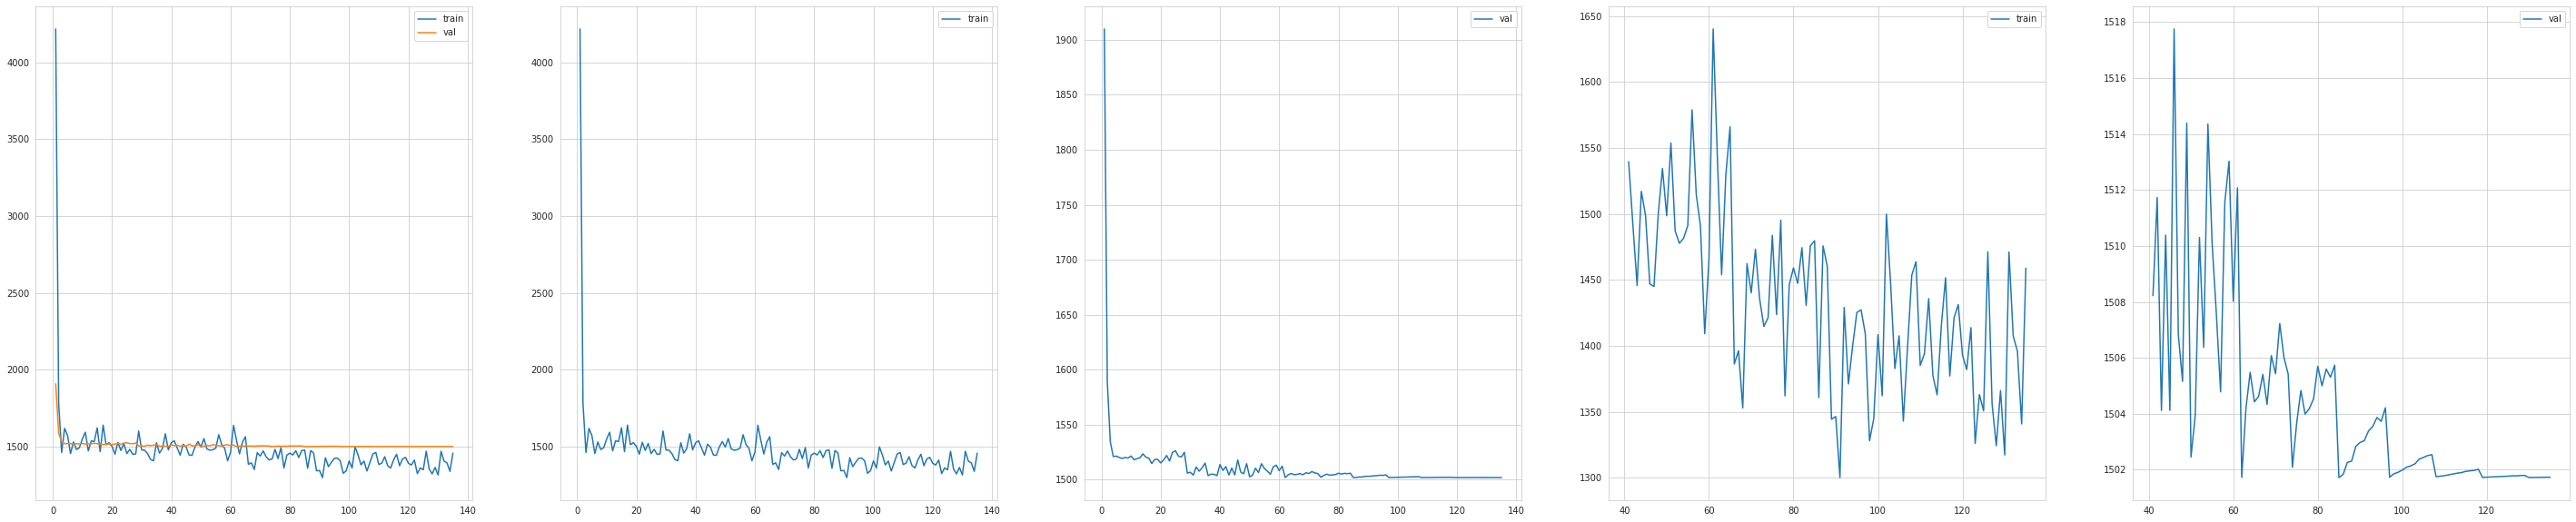

In [10]:
# bets before 1501
# plot training losses if we trained (additional plot after 40 epochs so we can see the later values better)
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [11]:
print(model)

FlowFA(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (la

In [12]:
from utility_extended import *

In [13]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: 2.013387612754576
Val loss: 1.9532103064083597
Test loss: 1.957517847953022


In [14]:
#torch.save(model, "./models/FlowFA")